In [7]:
import pandas as pd
movies=pd.read_csv("C:/Users/Udith P Kidiyoor/Downloads/movie_rec_project/movies_ranked.csv")
movies.head()

,tconst,primaryTitle,startYear,rank,averageRating,numVotes,runtimeMinutes,directors,writers,genres,IMDbLink,Title_IMDb_Link
0,tt0111161,The Shawshank Redemption,1994,1,9.3,3140234,142,Frank Darabont,"Stephen King, Frank Darabont",Drama,"<a href=""https://www.imdb.com/title/tt0111161""...","<a href=""https://www.imdb.com/title/tt0111161""..."
1,tt0068646,The Godfather,1972,2,9.2,2192080,175,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola","Crime, Drama","<a href=""https://www.imdb.com/title/tt0068646""...","<a href=""https://www.imdb.com/title/tt0068646""..."
2,tt0468569,The Dark Knight,2008,3,9.1,3116358,152,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Go...","Action, Crime, Drama","<a href=""https://www.imdb.com/title/tt0468569""...","<a href=""https://www.imdb.com/title/tt0468569""..."
3,tt0167260,The Lord of the Rings: The Return of the King,2003,4,9.0,2133004,201,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens, P...","Adventure, Drama, Fantasy","<a href=""https://www.imdb.com/title/tt0167260""...","<a href=""https://www.imdb.com/title/tt0167260""..."
4,tt0108052,Schindler's List,1993,5,9.0,1566410,195,Steven Spielberg,"Thomas Keneally, Steven Zaillian","Biography, Drama, History","<a href=""https://www.imdb.com/title/tt0108052""...","<a href=""https://www.imdb.com/title/tt0108052""..."


In [8]:
movies = movies[['primaryTitle', 'genres', 'averageRating', 'rank']].copy()

In [9]:
#Extract genre names from JSON-like string
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

In [10]:
movies['genre_list'] = movies['genres'].str.split(', ')

In [11]:
from sklearn.preprocessing import StandardScaler

# Select relevant numeric features
final_features = movies[['averageRating', 'rank']]  # Add other numeric features if available

# Apply scaling
scaler = StandardScaler()
final_features = scaler.fit_transform(final_features)

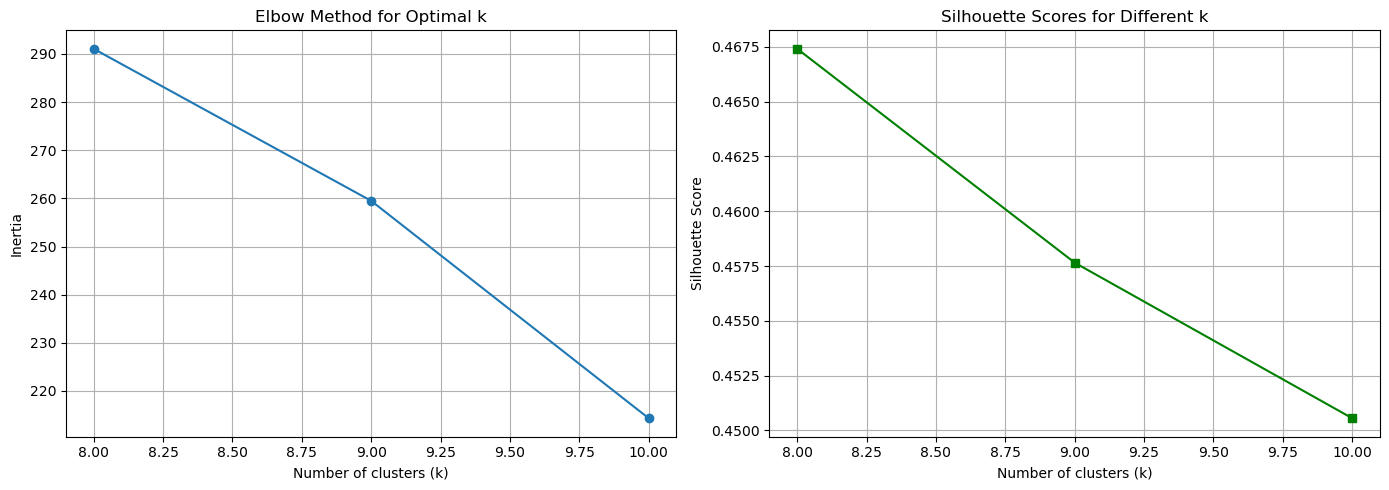

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia_values = []
silhouette_scores = []
k_values = range(8, 11)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

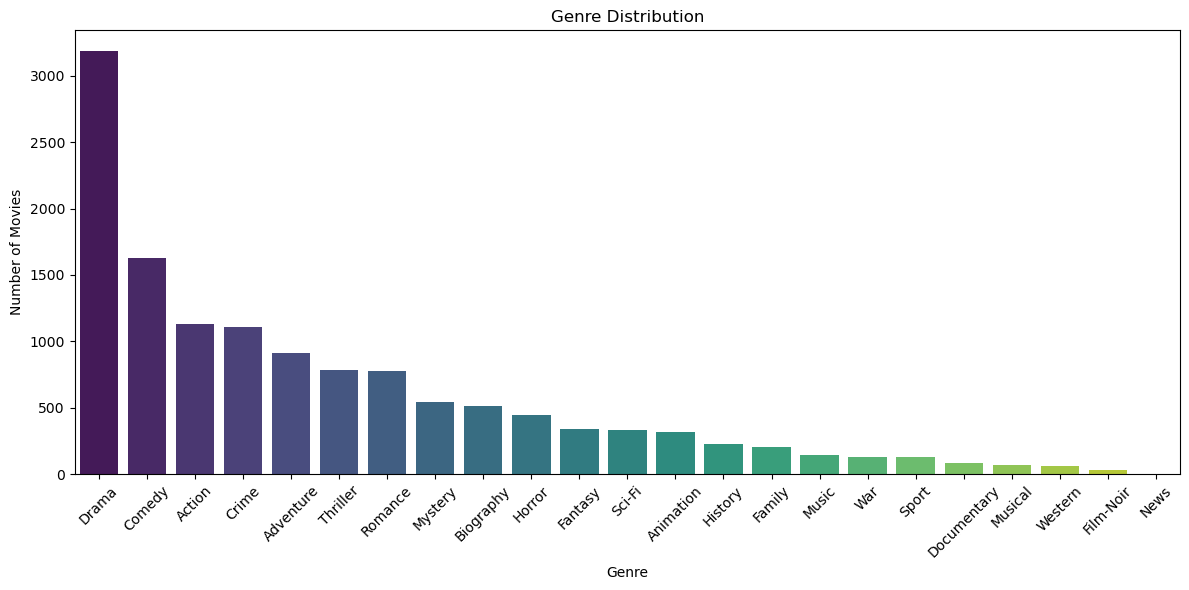

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette='viridis', legend=False)
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['averageRating', 'rank']])
scaled_df = pd.DataFrame(scaled_features, columns=['averageRating', 'rank'])

In [17]:
final_features = pd.concat([genre_df, scaled_df], axis=1)

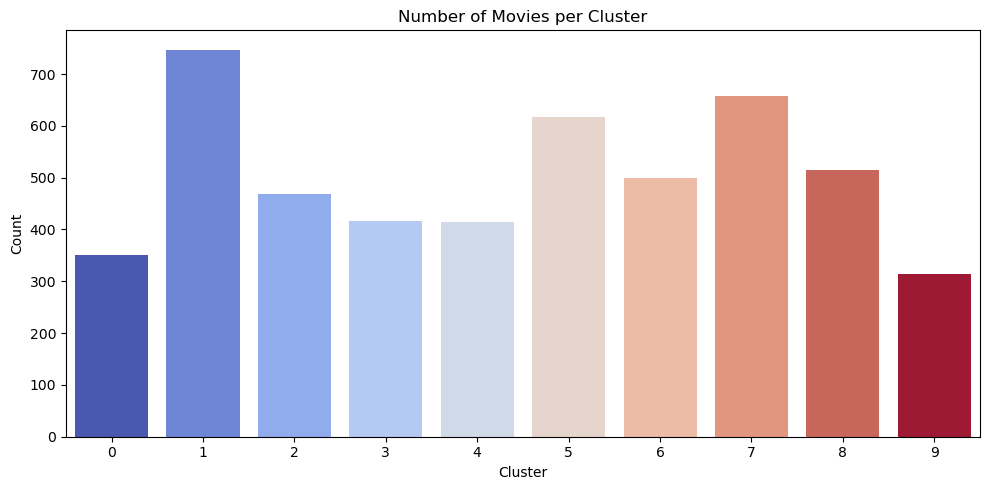

In [18]:
from sklearn.cluster import KMeans

optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], hue=movies['cluster'], palette='coolwarm', legend=False)
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies['combined_features'] = movies['primaryTitle'] + ' ' + movies['genre_list'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(stop_words='english')
feature_matrix = tfidf.fit_transform(movies['combined_features'])

similarity_matrix = cosine_similarity(feature_matrix)

In [20]:
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies using a hybrid approach: clustering + content-based filtering.
    
    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster with high similarity.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['primaryTitle'].str.lower() == movie_title.lower()]
    
    if target.empty:
        return f"Movie titled '{movie_title}' not found in dataset."
    
    # Get cluster of target movie
    cluster_id = target['cluster'].values[0]
    
    # Filter movies from the same cluster
    cluster_movies = movies[movies['cluster'] == cluster_id]
    
    # Find cosine similarity within the cluster
    target_index = target.index[0]
    similarity_scores = similarity_matrix[target_index]

    # Sort by similarity within the cluster
    cluster_movies['similarity'] = similarity_scores[movies.index.isin(cluster_movies.index)]
    recommended_movies = cluster_movies.sort_values(by=['similarity', 'averageRating', 'rank'], ascending=False)

    # Remove the input movie and return top N recommendations
    return recommended_movies[recommended_movies['primaryTitle'].str.lower() != movie_title.lower()][['primaryTitle', 'averageRating', 'rank']].head(n)

In [21]:
movie_name = "Ice Age"
recommended_movies_df = recommend_movies(movie_name, n=5)

print(f"Recommended movies similar to '{movie_name}':")
print(recommended_movies_df)

Recommended movies similar to 'Ice Age':
                        primaryTitle  averageRating  rank
3724           Ice Age: The Meltdown            6.8  3725
3311  Ice Age: Dawn of the Dinosaurs            6.9  3312
4568      Ice Age: Continental Drift            6.5  4569
3104           The Croods: A New Age            6.9  3105
73                                Up            8.3    74


C:\Users\Udith P Kidiyoor\AppData\Local\Temp\ipykernel_22972\145767921.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_movies['similarity'] = similarity_scores[movies.index.isin(cluster_movies.index)]
